In [55]:
import pandas as pd
import numpy as np
import datetime as dt
import calendar
import logging
from statsmodels.tsa.holtwinters import ExponentialSmoothing      
from statsmodels.tsa.seasonal import STL    
import scipy.stats as st 
from functools import reduce 
from numba import njit, jit

import os
import sys
parent = os.path.dirname(os.getcwd())  # workaround to import from utils/
sys.path.append(parent)
import matplotlib.pyplot as pp
from utils.db_utils import df_from_snowflake
pd.option_context('display.max_rows', None,)
pp.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')


metrics = ['BOOKING_REVENUES'
        #    'BOOKING_REVENUES_AFTER_CANCELLATIONS',
        #    'IFRS_REVENUES'
           ] 

def decompose_seasonality(data, revenue_column:int):
    """return residuals from decomposition process"""
    stl = STL(data.iloc[:,revenue_column], 
              period=365, 
              seasonal=13, 
              robust=True) 
    result = stl.fit()
    return result.resid, result.trend, result.seasonal 

@jit
def circular_block_bootstrap(block_size:int, data:pd.Series, n_bootstraps:int):
    num_items = len(data)
    num_blocks = num_items // block_size
    if num_blocks * block_size < num_items:
        num_blocks += 1
    dc = []
    for n in np.arange(n_bootstraps):
        indices = np.random.randint(num_items, size=num_blocks)
        indices = indices[:, None] + np.arange(block_size)
        indices = indices.flatten()
        indices %= num_items

        if indices.shape[0] > num_items:
            dc.append(data[indices[: num_items]])
        else:
            dc.append(data[indices])
    df = pd.DataFrame(np.array(dc)).T
    return df



# def make_bootstrap(data:np.array, bootstrap_time:int):
#     """bootstrap from array"""
#     dc = []
#     sample_size = data.shape[0]
#     idx = [i for i in range(sample_size)]
#     # loop through the required number of bootstraps
#     for b in range(bootstrap_time):
#         # obtain boostrap samples with replacement
#         sidx   = np.random.choice(idx, replace=True, size=sample_size)
#         b_samp = data[sidx]
#         dc.append(b_samp)
#     df = pd.DataFrame(np.array([dc][:][:][0])).T
#     return(df)


def processing(data:pd.DataFrame,revenue_column:int):
    """
    Pipeline: decompose -> bootstrap.
    Return dataframe
    """
    rediduals, trend, seasonal = decompose_seasonality(data, revenue_column)
    # bootstrapped_residuals = make_bootstrap(rediduals, bootstrap_time=50)
    bootstrapped_residuals = circular_block_bootstrap(3, rediduals, n_bootstraps=49)
    #get back full data by adding back bootstrapped resid with trend and seasonal
    df = (bootstrapped_residuals.T + trend + seasonal).T
    negative_col = df.lt(0).all()
    non_negative_df = df.loc[:, ~negative_col]
    return non_negative_df


def mean_confidence_interval(data:pd.DataFrame):
    """take each row values and return mean, lower, upper"""
    lens = len(data)
    mean = []
    lower = []
    upper = []
    for row in range(0,lens):
        a = 1.0 * np.array(data.iloc[row,:])
        n = len(a)
        m, se = np.mean(a), st.sem(a)
        std = st.tstd(a)
        mean.append(m)
        lower.append(m-std)
        upper.append(m+std)
    return mean, lower, upper


#######Exponential Smoothing fuction########
def exponential_smoothing(data,date_column,revenue_column):

    max_date_data = data.iloc[:, date_column].max() 
    first_date = max_date_data.replace(day=1)
    end_date = first_date + pd.offsets.MonthEnd(0)

    # x = (end_date - pd.to_datetime(first_date))

    # data = data[(data.iloc[:, date_column] < first_date)]

    x = (end_date - pd.to_datetime(max_date_data))
    data = data[(data.iloc[:, date_column] < max_date_data)]

    tes_model = ExponentialSmoothing(data.iloc[:, revenue_column],
                                    trend="add",
                                    seasonal="add",
                                    damped_trend=True,
                                    seasonal_periods=365
                                    ).fit()

    y_pred = tes_model.forecast(x.days+1)

    df_prediction = pd.DataFrame(pd.date_range(start=max_date_data, end=end_date), columns=['DATE'])
    df_prediction['prediction_value'] = y_pred.reset_index(drop=True)
    df_prediction.set_index('DATE', inplace=True)


    # monthly_revenue = df_prediction.resample('M').sum()
    # monthly_revenue.reset_index(inplace=True)

    return df_prediction


def run(input_df:pd.DataFrame, metrics:list, cut_off_date):
    input_df['DATE'] = pd.to_datetime(input_df['DATE'])
    input_df = input_df[input_df['DATE']< cut_off_date]
    #input_df['GROUP_KEY'] = input_df['SITE_ID'] + " | " + input_df['LEGAL_ENTITY'] + " | " + input_df['SITE_GLOBAL_REGION'] + " | " + input_df['DEAL_TYPE']
    input_df['GROUP_KEY'] = input_df['SITE_GLOBAL_REGION']
    unique_group_key = input_df['GROUP_KEY'].drop_duplicates().tolist()

    df_groups = pd.DataFrame()
    for _g, group in enumerate(unique_group_key): #loop thru subsets of entities

        if 'DACH' not in group:
            continue #skip loop iterations of non .de site_id, just for testing

        filtered_df = input_df[(input_df['GROUP_KEY'] == group)]

        if len(filtered_df) <= 720: #exclude small entities that don't have enough 2 full cycles
            continue

        df_metrics = pd.DataFrame()
        for _m, metric in enumerate(metrics): #loop thru reporting metrics
            grouped_df = filtered_df.groupby('DATE').agg({metric: lambda x: round(x.sum(), 0)}).reset_index()
            grouped_df.sort_values(by='DATE', inplace=True)

            bootstrapped_data = processing(grouped_df,1)
            cols = ['DATE'] + bootstrapped_data.columns.tolist()
            bootstrapped_data['DATE'] = pd.to_datetime(grouped_df['DATE'])
            bootstrapped_data = bootstrapped_data[cols]

            data_frames = []
            for i in range(1, len(bootstrapped_data.columns)): #loop thru bootstrapped datasets
                result_frames = exponential_smoothing(bootstrapped_data, 0, i)
                result_frames = result_frames.rename(columns={'prediction_value': f'prediction_{metric}_{i}'})
                data_frames.append(result_frames)

            merged_df = reduce(lambda left, right: pd.merge(left, right, on='DATE'), data_frames)
            mean, lower, upper = mean_confidence_interval(merged_df.iloc[:,1:])

            if _m < 1:
                df_metrics['PREDICTED_DATE'] = pd.to_datetime(merged_df.index)
                df_metrics.set_index('PREDICTED_DATE', inplace=True)
            merged_df[f'PREDICTED_{metric}'] = mean
            merged_df[f'LOWER_{metric}'] = lower
            merged_df[f'UPPER_{metric}'] = upper

            # merged_df = merged_df[['BACKTEST_DATE', 'GROUP', f'PREDICTED_{metric}', f'LOWER_{metric}', f'UPPER_{metric}' ]]
            merged_df = merged_df.iloc[:,-3:]

            df_metrics = pd.concat([df_metrics, merged_df], axis=1)   #should be concat horizontally

        df_metrics[f'FORECAST_GROUP'] = [ group for i in range(0,len(df_metrics))]
        df_groups = pd.concat([df_groups,df_metrics], axis=0)    #should be concat vertically

    df_groups['BACKTEST_DATE'] = [cut_off_date for i in range(0,len(df_groups))]
    #return df_groups[0][0][:]
    return df_groups
   

In [27]:
input_df = df_from_snowflake(query="select * from dev.reporting_finance.dcs_input_data")
input_df

,DATE,SITE_ID,LEGAL_ENTITY,SITE_GLOBAL_REGION,INTER_COMPANY_GROUP,DEAL_TYPE,SESSIONS,SPEND,BOOKING_QUANTITY,BOOKING_REVENUES,BOOKING_REVENUES_AFTER_CANCELLATIONS,IFRS_REVENUES,BOOKING_QUANTITY_PREVIOUS_DAY
0,2024-05-17,such.hometogo.de,hometogo,DACH,False,Offsite - CPA,NaN,NaN,0,0.00000,0.000000,0.000000,0
1,2024-05-17,suche.bretagne-mit-hund.de,hometogo,DACH,False,Onsite - CPA,38.0,0.00000,0,0.00000,0.000000,0.000000,0
2,2024-05-17,suche.frankreich-mit-hund.de,hometogo,DACH,False,Onsite - CPA,45.0,0.00000,0,0.00000,0.000000,0.000000,0
3,2024-05-17,suche.hunde-ferienhaeuser.de,hometogo,DACH,False,Onsite - CPA,654.0,196.36226,4,437.00300,369.619882,0.000000,4
4,2024-05-17,suche.hunde-ferienhaeuser.de,hometogo,DACH,False,Offsite - CPA,NaN,NaN,0,0.00000,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
247244,2024-02-24,casamundo.com,hometogo,North America,False,Onsite - CPA,2237.0,0.60000,11,1930.69100,1245.222477,68.777021,11
247245,2024-02-24,casamundo.com,hometogo,North America,False,Others - CPC & CPL,NaN,NaN,0,6.00000,6.000000,6.000000,0
247246,2024-02-24,casamundo.de,hometogo,DACH,False,Onsite - CPA,73668.0,27914.40536,389,56477.83082,45233.689735,694.794656,389
247247,2024-02-24,casamundo.de,hometogo,DACH,False,Offsite - CPA,NaN,NaN,1,41.28000,38.803200,0.000000,1


In [28]:
filtered_df = input_df[(input_df['SITE_GLOBAL_REGION'] == 'DACH')]
filtered_df['DATE'] = pd.to_datetime(filtered_df['DATE'])
grouped_df = filtered_df.groupby('DATE').agg({'BOOKING_REVENUES': lambda x: round(x.sum(), 0)}).reset_index()
sorted_df = grouped_df.sort_values(by='DATE')

In [37]:
bootstrap = processing(sorted_df,1)
cols = ['DATE'] + bootstrap.columns.tolist()
bootstrap['DATE'] = pd.to_datetime(sorted_df['DATE'])
bootstrapped_data = bootstrap[cols]

In [38]:
bootstrap

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,DATE
0,155039.794882,156205.002748,50762.447822,290431.688277,157959.004125,153077.291267,157276.112616,224224.189942,158556.815365,286020.011174,...,255630.062271,161503.639434,180830.020090,337937.058101,165789.776549,161468.570006,177749.143165,169523.443541,162373.102332,2020-01-01
1,129731.066964,128785.130819,136719.370590,343270.422004,170929.752528,144226.271103,160842.471004,122206.406637,137735.769671,140952.777509,...,225052.059126,126407.985211,155621.515912,164306.032133,143281.030950,134820.163899,161053.987001,137337.521476,140864.551817,2020-01-02
2,159304.720728,136606.364838,165194.873751,264258.679067,146879.509152,314961.787669,83546.973765,333656.943476,159508.211769,84926.765357,...,245604.639192,158323.719477,182865.108283,156536.351076,152437.376359,177592.281557,155740.574031,157266.167105,158107.865839,2020-01-03
3,176071.635256,178986.742979,171927.959469,200543.268365,180089.002762,109493.791522,170479.456945,185441.078010,111664.580969,212421.200863,...,17201.247366,154863.786725,184259.563238,180815.561985,139360.266515,178918.254108,167225.371348,173934.343889,181200.435521,2020-01-04
4,232645.086587,226252.229651,225401.555225,239851.556179,237789.904848,246355.912468,242569.254103,241993.573654,215541.319030,244996.709775,...,110895.621228,187612.685699,243255.278063,246595.400159,229867.765980,485396.270098,249308.137702,246923.020840,241038.903806,2020-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1674,168025.321585,147758.999674,163776.471647,103146.352492,225653.479494,159657.674171,166891.273053,172803.482696,168203.461329,152225.774388,...,179936.164773,246754.288726,151742.958299,162145.048712,163819.519163,158455.396392,171478.785225,158176.451214,170046.215792,2024-08-01
1675,262710.064457,166726.096621,165932.855994,110297.437155,219495.236233,162912.009091,158701.499565,283253.585543,161662.953446,150976.557353,...,171624.332446,245173.047805,160120.851581,151506.921447,167311.559247,163726.584421,161860.577845,157641.251625,156733.985852,2024-08-02
1676,154934.207411,132786.133301,126395.790725,97211.346969,218918.967235,59740.762460,139414.883608,188419.365600,147312.998580,115590.936990,...,167039.816055,228964.549667,137603.053017,138144.951574,143964.636629,153790.106654,134071.148519,149948.682523,136634.838110,2024-08-03
1677,154860.603538,102236.355779,154885.768663,156186.872007,170841.578985,116963.341692,158621.981271,342768.154734,145576.032298,142350.544044,...,154865.655412,167876.163617,139552.122401,165869.733293,120907.171490,155769.915442,172787.873255,96060.787450,154116.921495,2024-08-04


In [14]:
#output = run(input_df, metrics, cut_off_date='2023-07-04')

## Evaluate

In [66]:
def evaluate(df:pd.DataFrame, cut_off_date):
    query="""
            select date,
                    site_global_region,
                    sum(booking_revenues) as actual_booking_revenues
                from stage.reporting_finance.dcs_input_data
                where true
                -- and site_id= 'hometogo.de'
                and site_global_region= 'DACH'
                and date_trunc('month', date) = date_trunc('month', to_date('{date}','YYYY-MM-DD'))
                group by all
                order by 2,  1 asc;
            """.format(date=cut_off_date)
    actual = df_from_snowflake(query=query)
    actual['DATE'] = pd.to_datetime(actual['DATE'])
    

    pred = run(input_df, metrics=metrics ,cut_off_date=cut_off_date)
    pred['DATE']= pd.to_datetime(pred.index)
    pred.sort_values(by='DATE', inplace=True)
    pred.reset_index(inplace=True)

    first_date = pd.to_datetime(cut_off_date).replace(day=1)
    end_date = pd.to_datetime(cut_off_date)
    filled_actual = pd.DataFrame(pd.date_range(start=first_date, end=end_date), columns=['DATE'])
    filled_actual['PREDICTED_BOOKING_REVENUES'] = actual[(actual['DATE']>=first_date) & (actual['DATE']<=end_date)]['ACTUAL_BOOKING_REVENUES']
    filled_actual['LOWER_BOOKING_REVENUES'] = actual[(actual['DATE']>=first_date) & (actual['DATE']<=end_date)]['ACTUAL_BOOKING_REVENUES']
    filled_actual['UPPER_BOOKING_REVENUES'] = actual[(actual['DATE']>=first_date) & (actual['DATE']<=end_date)]['ACTUAL_BOOKING_REVENUES']


    rolling_pred = pd.concat([filled_actual,pred], axis=0)

    combine_df = pd.merge(rolling_pred, actual, on='DATE',how='left')
    combine_df['DATE'] = pd.to_datetime(combine_df['DATE'], format= "%Y-%m")
    combine_df.sort_values(by='DATE', inplace=True)
    combine_df.set_index('DATE', inplace=True)

    #PLOT
    _,ax = pp.subplots(nrows=1, ncols=2, figsize=(12,5))
    ax[0].set_title(f'daily - pred cut-off {cut_off_date}')

    ax[0].fill_between(combine_df.index,
                    np.array(combine_df['LOWER_BOOKING_REVENUES']),
                    np.array(combine_df['UPPER_BOOKING_REVENUES']),
                    alpha=0.2,
                    color='blue'
                    )
    ax[0].plot(combine_df['PREDICTED_BOOKING_REVENUES'], label='pred', color='red', linestyle='--')
    ax[0].plot(combine_df['ACTUAL_BOOKING_REVENUES'], label='actual', color='black')
    ax[0].tick_params(axis='x', labelrotation=90)
    ax[0].legend()


    ax[1].plot(combine_df['PREDICTED_BOOKING_REVENUES'].cumsum(), label='pred', color='red', linestyle='--')
    ax[1].fill_between(combine_df.index,
                    np.array(combine_df['LOWER_BOOKING_REVENUES'].cumsum()),
                    np.array(combine_df['UPPER_BOOKING_REVENUES'].cumsum()),
                    alpha=0.2,
                    color='blue'
                    )
    ax[1].plot(combine_df['ACTUAL_BOOKING_REVENUES'].cumsum(), label='actual', color='black')
    ax[1].tick_params(axis='x', labelrotation=90)
    ax[1].legend()
    pred_sum = combine_df['PREDICTED_BOOKING_REVENUES'].sum()
    actual_sum = combine_df['ACTUAL_BOOKING_REVENUES'].sum()
    text_str = f'pred: {np.int64(pred_sum)} vs actual: {np.int64(actual_sum)} | diff: {round((np.int64(pred_sum)- np.int64(actual_sum))/np.int64(actual_sum),2)}'
    ax[1].set_title(text_str) 

    # ax[2].hist(combine_df.iloc[:,0:198].sum(axis=0))
    # ax[2].set_title('hometogo.de')
    # ax[2].set_xlabel('million')
    pp.show()

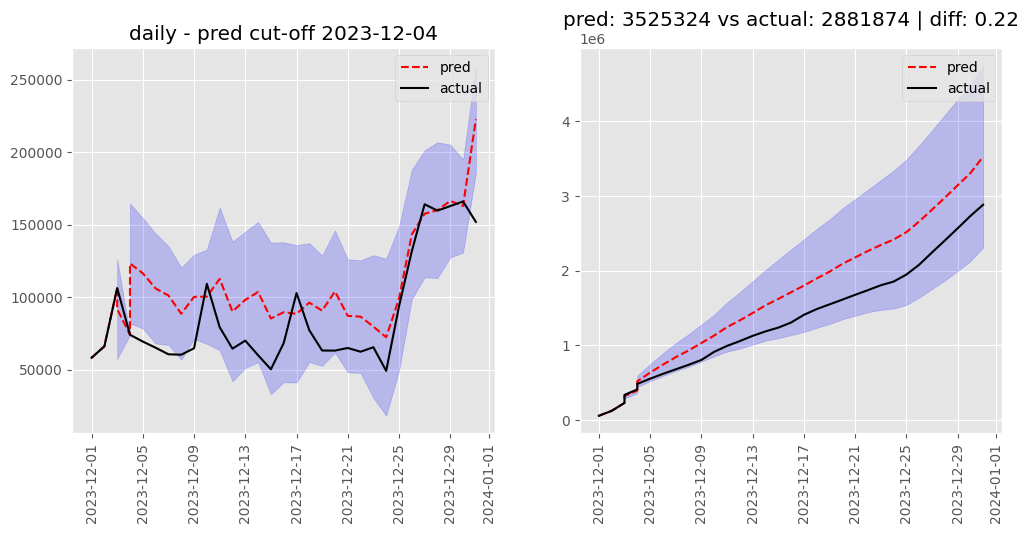

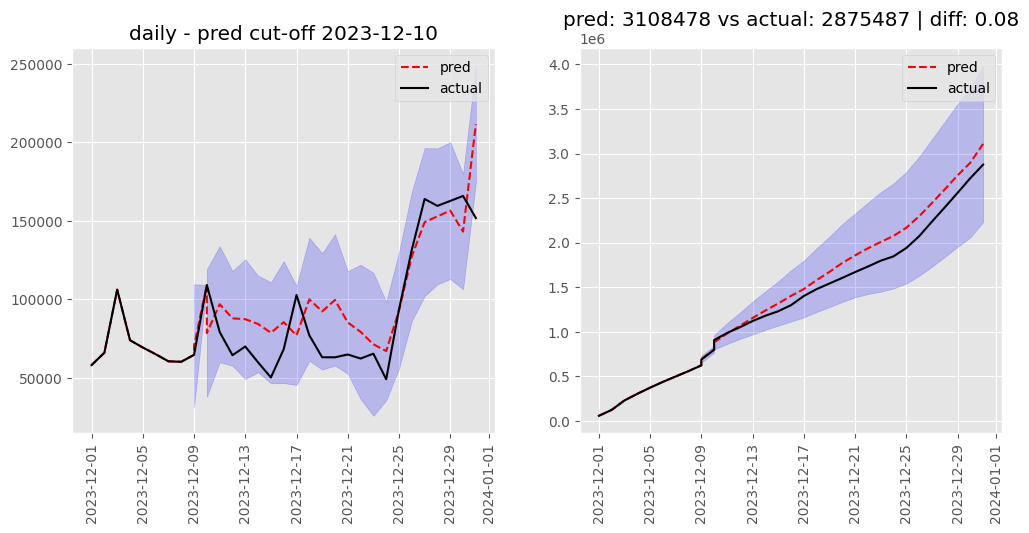

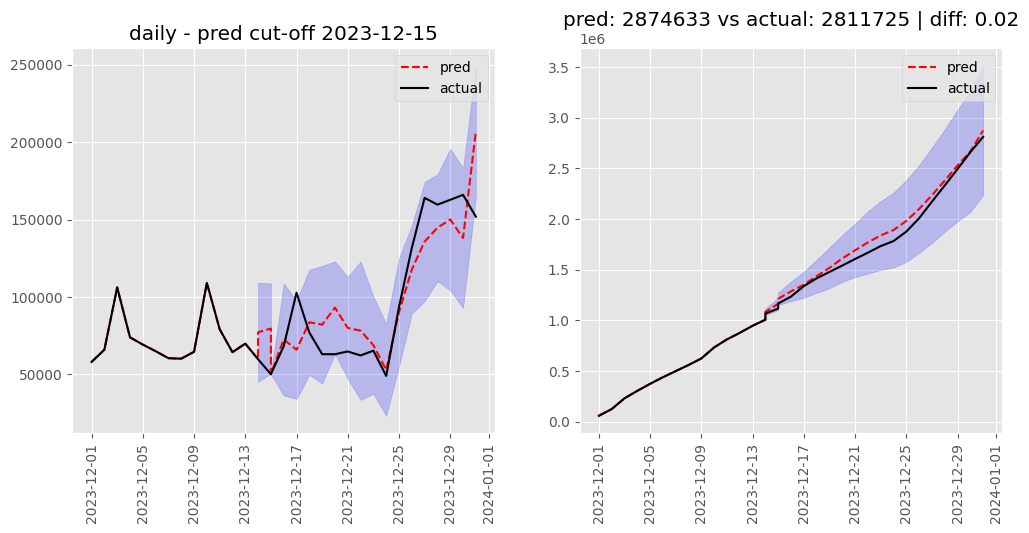

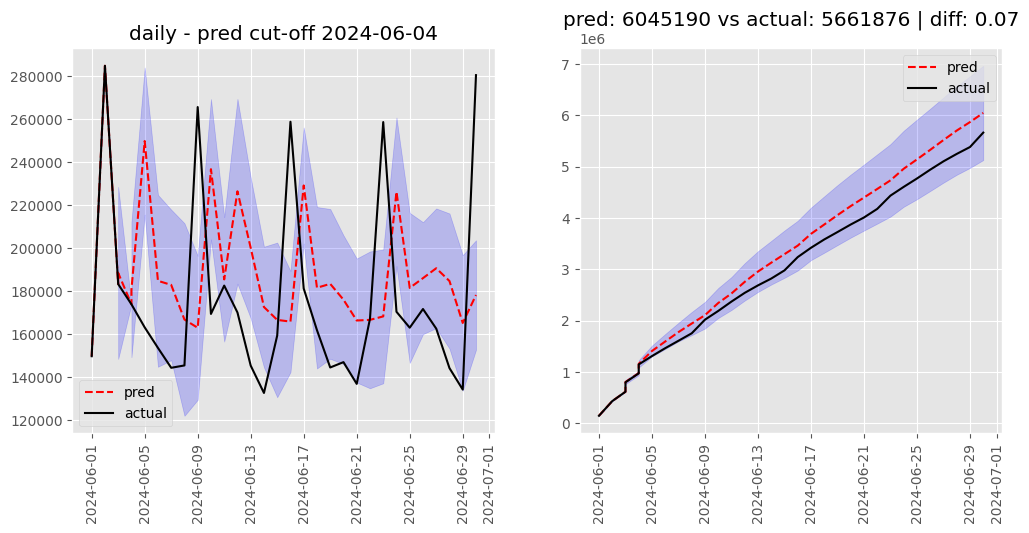

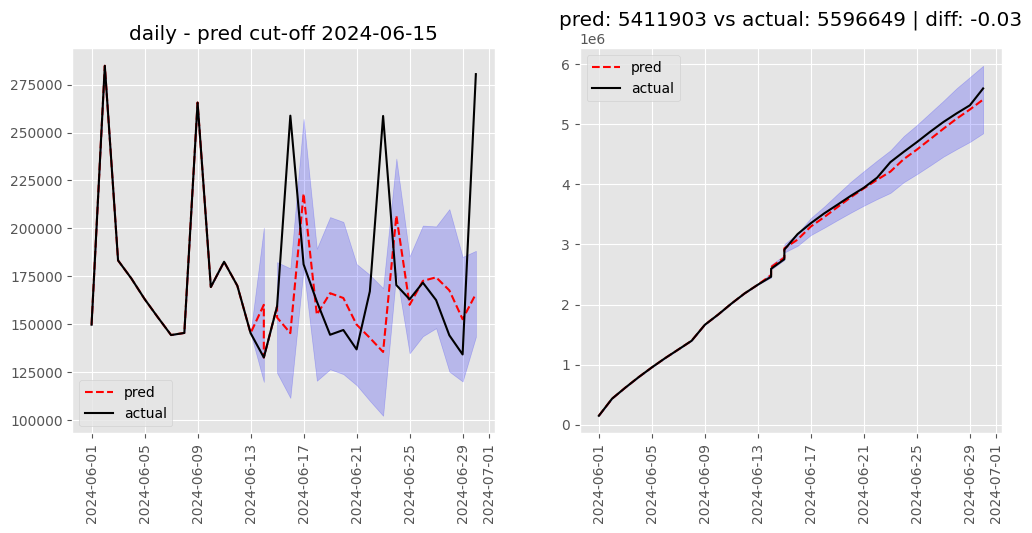

In [67]:
dates = [
        # '2023-07-10',
        # '2023-07-15',
        # '2023-11-07',
        '2023-12-04',
        '2023-12-10',
        '2023-12-15',
        # '2024-01-05',
        # '2024-02-04',
        # # '2024-02-10',
        # '2024-02-15',
        '2024-06-04',
        # '2024-06-10',
        '2024-06-15'
    ]

for date in dates:
    evaluate(input_df ,date)